In [19]:
import numpy as np
from matplotlib import pyplot
from dataclasses import dataclass
import math


## Functions

In [20]:
class Function:
    @staticmethod
    def sphere(x, y):
        return x**2 + y**2

    @staticmethod
    def schwefel(x, y):
        return 418.9829 * 2 - x * np.sin(np.sqrt(abs(x))) - y * np.sin(np.sqrt(abs(y)))


    @staticmethod
    def rosenbrock(x, y):
        return (1 - x)**2 + 100 * (y - x**2)**2

    @staticmethod
    def rastrigin(x, y):
        term = 10 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))
        return x**2 + y**2 - term + 20

    @staticmethod
    def griewangk(x, y):
        left = (x**2 + y**2) / 4000
        right = np.cos(x / np.sqrt(2)) * np.cos(y / np.sqrt(2))
        return left - right + 1

    @staticmethod
    def levy(x, y):
        sin_3pi_x = np.sin(3 * np.pi * x)
        sin_3pi_y = np.sin(3 * np.pi * y)
        return sin_3pi_x**2 + (x - 1)**2 * (1 + sin_3pi_y**2) + (y - 1)**2 * (1 + np.sin(2 * np.pi * y)**2)

    @staticmethod
    def michalewicz(x, y):
        sin_x = np.sin(x)
        sin_y = np.sin(y)
        return -1 * (sin_x * np.sin((1 * x**2) / np.pi)**20 + sin_y * np.sin((2 * y**2) / np.pi)**20)

    @staticmethod
    def zakharov(x, y):
        term = 0.5 * x + y
        return x**2 + y**2 + term**2 + term**4

    @staticmethod
    def ackley(x, y):
        term_1 = -0.2 * np.sqrt(0.5 * (x**2 + y**2))
        term_2 = np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)
        return -20 * np.exp(term_1) - np.exp(0.5 * term_2) + np.e + 20


## Solution

TypeError: 'Point' object is not iterable

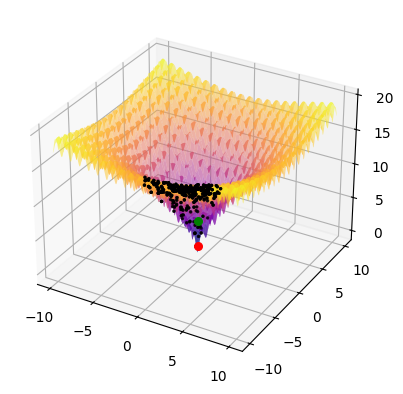

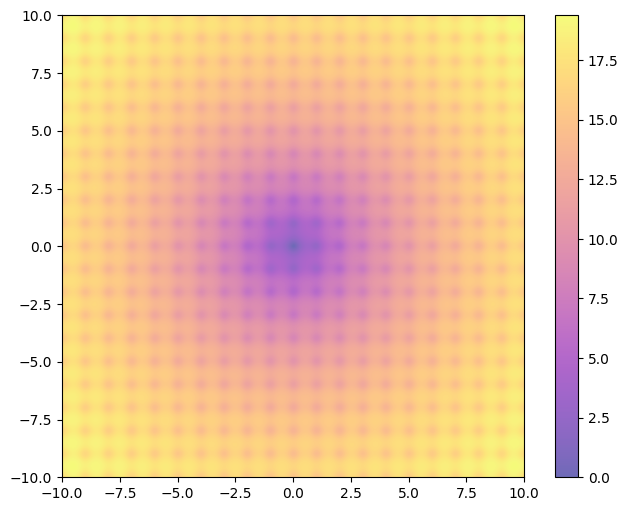

In [21]:
LOWER_BOUND = -10.0
UPPER_BOUND = 10.0
POINT_SPACING = 0.01
DIMENSION = "3d"

@dataclass
class Point:
    x: float
    y: float
    z: float

class Solution:
    def __init__(self, dimension:str=DIMENSION, lower_bound:float=LOWER_BOUND, upper_bound:float=UPPER_BOUND, point_spacing:float=POINT_SPACING, function=None):
        self.dimension = dimension
        self.lower_bound = lower_bound  
        self.upper_bound = upper_bound
        self.function = function
        # Points in given range
        self.raw_points = np.arange(self.lower_bound, self.upper_bound, point_spacing)
        # Create meshgrid - matrices from X and Y points
        self.surface_x, self.surface_y = np.meshgrid(self.raw_points, self.raw_points)
        # Generate Z coordinate from given function
        self.surface_z = self.function(self.surface_x, self.surface_y)
        self.init_plot()
        self.init_heat_map()

    def init_plot(self):
        self.figure = pyplot.figure(figsize=(16,10))
        self.plot = self.figure.add_subplot(131, projection=self.dimension, computed_zorder=False)
        self.plot.plot_surface(self.surface_x, self.surface_y, self.surface_z, cmap='plasma', alpha=0.5, zorder=1)

    def plot_points(self, points, color="black", size:int=2, zorder:int=2):
        # Extract x, y, z coordinates from points
        x_points = [point.x for point in points]
        y_points = [point.y for point in points]
        z_points = [point.z for point in points]
        self.plot.scatter(x_points, y_points, z_points, c=color, s=size, zorder=zorder)

    def init_heat_map(self):
        # Create a figure for the heat map
        self.heatmap_figure = pyplot.figure(figsize=(8, 6))
        self.heatmap_plot = self.heatmap_figure.add_subplot(111)

        # Generate heatmap of the surface_z function values
        heat_map = self.heatmap_plot.imshow(self.surface_z, extent=(self.lower_bound, self.upper_bound, self.lower_bound, self.upper_bound), origin='lower', cmap='plasma', alpha=0.6)

        # Add a color bar to interpret the Z-values
        self.heatmap_figure.colorbar(heat_map)

    def plot_heat_map_points(self, points, color="black", size=10):
        # Extract x, y coordinates from points and plot them on the heatmap
        x_points = [point.x for point in points]
        y_points = [point.y for point in points]
        self.heatmap_plot.scatter(x_points, y_points, c=color, s=size)

    def simulated_annealing(self, initial_temperature: float, cooling_rate: float, minimum_temperature: float):
        # Generate random initial point and set it as current and best
        x: float                = np.random.uniform(self.lower_bound, self.upper_bound)
        y: float                = np.random.uniform(self.lower_bound, self.upper_bound)
        z: float                = self.function(x, y)
        current_point           = Point(x, y, z)
        best_point: Point       = current_point
        start_point: Point      = current_point
        all_points              = []
        current_temperature     = initial_temperature

        while current_temperature > minimum_temperature:

            # Generate a random neighbor
            neighbor_x: float = current_point.x + np.random.uniform(-1, 1)
            neighbor_y: float = current_point.y + np.random.uniform(-1, 1)
            neighbor_z: float = self.function(neighbor_x, neighbor_y)

            # Make sure that new point is not generated outside boundaries
            if (neighbor_x > self.upper_bound or neighbor_x < self.lower_bound) or (neighbor_y > self.upper_bound or neighbor_y < self.lower_bound):
                continue

            # Calculate the energy difference
            energy_difference: float = neighbor_z - current_point.z

            # Update the best point if necessary
            if neighbor_z < current_point.z:
                current_point = Point(neighbor_x, neighbor_y, neighbor_z)
                all_points.append(current_point)

            # Accept or reject the neighbor
            if np.random.random() < math.exp(-energy_difference / current_temperature):
                current_point = Point(neighbor_x, neighbor_y, neighbor_z)
                all_points.append(current_point)

            all_points.append(current_point)

            # Update the best point if necessary
            if current_point.z < best_point.z:
                best_point = Point(current_point.x, current_point.y, current_point.z)

            # Cool down the temperature
            current_temperature *= cooling_rate

        return best_point, all_points, start_point


functions = [
    # Function.sphere,
    # Function.schwefel,
    # Function.rosenbrock,
    # Function.rastrigin,
    # Function.griewangk,
    # Function.levy,
    # Function.michalewicz,
    # Function.zakharov,
    Function.ackley
]

# Iterate over each function and generate the graph
for func in functions:
    solution = Solution(DIMENSION, LOWER_BOUND, UPPER_BOUND, POINT_SPACING, func)

    sa_best_point, sa_all_points, sa_start_point = solution.simulated_annealing(200.0, 0.98, 0.1)
    solution.plot_points(sa_all_points, color='black', size=2, zorder=2)
    solution.plot_points([sa_best_point], color='red', size=30, zorder=3)
    solution.plot_points([sa_start_point], color='green', size=30, zorder=3)

    solution.plot_heat_map_points(sa_all_points, color='black', size=10)  # Plot all points
    solution.plot_heat_map_points([sa_start_point], color='green', size=50)  # Plot starting point
    solution.plot_heat_map_points([sa_best_point], color='red', size=50)  # Plot the best point found

    pyplot.show()